In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']= '2'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']= 'false'
os.environ['MUJOCO_GL']= 'egl'
os.environ['EGL_DEVICE_ID'] = '2' 
print("CUDA_VISIBLE_DEVICES =", os.environ.get('CUDA_VISIBLE_DEVICES'))
import jax
print("JAX devices:", jax.devices())


CUDA_VISIBLE_DEVICES = 2
JAX devices: [CudaDevice(id=0)]


In [2]:
import  sys
from datetime import datetime
from pathlib import Path
from types import SimpleNamespace
from typing import Callable, NamedTuple, Tuple
proj = Path.home() / "distributionally_robust_learning"
sys.path.insert(0, str(proj))
os.environ['PYTHONPATH'] = os.environ.get("PYTHONPATH","") + "~/distributionally_robust_learning"
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from learning.module.target_examples.funnel import Funnel
from learning.module.target_examples.gmm40 import GMM40
import functools
import chex


Setup GMMVI

In [3]:
from learning.module.gmmvi.network import create_gmm_network_and_state
from learning.module.gmmvi.network import GMMTrainingState
from learning.module.target_examples.student_t_mixture import StudentTMixtureModel
dim=2

target = StudentTMixtureModel(dim=dim, sample_bounds=[-30., 30.], num_components=40)
target = GMM40(dim=dim)
target = Funnel(dim=dim, sample_bounds=[-30, 30])
low = jnp.array([-10,-5])
# low = jnp.array([-30,-30])
# low = jnp.array([-target._plot_bound, -target._plot_bound])
high = jnp.array([5, 5])
# high = jnp.array([target._plot_bound, target._plot_bound])


key= jax.random.PRNGKey(0)
num_envs=128
batch_size=1024
bound_info = low, high
initial_train_state, gmm_network = create_gmm_network_and_state(dim, num_envs, batch_size, key, prior_scale=.5, bound_info=bound_info)


/home/tjrcjf410/miniconda3/envs/mujoco_jax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:


def train_iter(train_state: GMMTrainingState, key: chex.Array, target_log_prob_fn):
    def get_target_grads(samples: chex.Array) -> Tuple[chex.Array, chex.Array]:
        # samples = jnp.tanh(samples) * (high-low)/2 + (high+low)/2
        target, gradient = jax.vmap(jax.value_and_grad(target_log_prob_fn))(samples)
        # target += jnp.log(1- ((2*samples-(low+high))/(high-low))**2).sum(-1)

        return gradient, target
    key, subkey = jax.random.split(key)
    new_samples, mapping = gmm_network.sample_selector.select_samples(train_state.model_state,
                                        subkey)
    new_target_grads, new_target_lnpdfs = get_target_grads(new_samples)
    new_sample_db_state = gmm_network.sample_selector.save_samples(train_state.model_state, train_state.sample_db_state, new_samples, new_target_lnpdfs, new_target_grads, mapping)
    samples, mapping, sample_dist_densities, target_lnpdfs, target_lnpdf_grads = \
        gmm_network.sample_selector.select_train_datas(new_sample_db_state)

    new_component_stepsizes = gmm_network.component_stepsize_fn(train_state.model_state)
    new_model_state = gmm_network.model.update_stepsizes(train_state.model_state, new_component_stepsizes)
    expected_hessian_neg, expected_grad_neg = gmm_network.more_ng_estimator(new_model_state,
                                                            samples,
                                                            sample_dist_densities,
                                                            target_lnpdfs,
                                                            target_lnpdf_grads)
    new_model_state = gmm_network.component_updater(new_model_state,
                                    expected_hessian_neg,
                                    expected_grad_neg,
                                    new_model_state.stepsizes)

    new_model_state = gmm_network.weight_updater(new_model_state, samples, sample_dist_densities, target_lnpdfs,
                                                    train_state.weight_stepsize)
    new_num_updates = train_state.num_updates + 1
    key, subkey = jax.random.split(key)
    new_model_state, new_component_adapter_state, new_sample_db_state = \
        gmm_network.component_adapter(train_state.component_adaptation_state,
                                                    new_sample_db_state,
                                                    new_model_state,
                                                    new_num_updates,
                                                    subkey)
    return GMMTrainingState(temperature=train_state.temperature,
                        model_state=new_model_state,
                        component_adaptation_state=new_component_adapter_state,
                        num_updates=new_num_updates,
                        sample_db_state=new_sample_db_state,
                        weight_stepsize=train_state.weight_stepsize)
def eval(seed: chex.Array, train_state: GMMTrainingState, target_log_prob_fn, n_eval_samples, target_samples=None):
    samples = gmm_network.model.sample(train_state.model_state.gmm_state, seed, n_eval_samples)[0]
    def log_prob_model_fn(sample):
        log_prob = jax.vmap(functools.partial(gmm_network.model.log_density, gmm_state=train_state.model_state.gmm_state))(sample=sample)
        bijector_log_prob = lambda x : jnp.log(2 * jnp.ones_like(low)).sum(-1) -jnp.log(high-low).sum(-1)-jnp.log(1- ((2*x-(low+high))/(high-low))**2).sum(-1)
        return log_prob #- bijector_log_prob(sample)
    log_prob_model = log_prob_model_fn(sample=samples)
    log_prob_target = jax.vmap(target_log_prob_fn)(samples)
    log_ratio = log_prob_target - log_prob_model
    if target_samples is not None:
        fwd_log_prob_model = jax.vmap(gmm_network.model.log_density, in_axes=(None, 0))(train_state.model_state.gmm_state, target_samples)
        fwd_log_prob_target = jax.vmap(target_log_prob_fn)(target_samples)
        fwd_log_ratio = fwd_log_prob_target - fwd_log_prob_model
    else:
        fwd_log_ratio = None

    return samples, log_ratio, log_prob_target, fwd_log_ratio, n_eval_samples, log_prob_model_fn


In [5]:
from time import time

logger = {
    'KL/elbo': [],
    'KL/eubo': [],
    'logZ/delta_forward': [],
    'logZ/forward': [],
    'logZ/delta_reverse': [],
    'logZ/reverse': [],
    'ESS/forward': [],
    'ESS/reverse': [],
    'discrepancies/mmd': [],
    'discrepancies/sd': [],
    'other/target_log_prob': [],
    'other/EMC': [],
    "stats/step": [],
    "stats/wallclock": [],
    "stats/nfe": [],
}
def eval_fn(samples, log_ratio, target_log_prob, fwd_log_ratio, n_eval_samples, model_log_prob_fn):
    ln_z = jax.nn.logsumexp(log_ratio) - jnp.log(n_eval_samples)
    elbo = jnp.mean(log_ratio)

    if target.log_Z is not None:
        logger['logZ/delta_reverse'].append(jnp.abs(ln_z - target.log_Z))

    logger['logZ/reverse'].append(ln_z)
    logger['KL/elbo'].append(elbo)
    # logger['ESS/reverse'].append(compute_reverse_ess(log_ratio, n_eval_samples))
    logger['other/target_log_prob'].append(jnp.mean(target_log_prob))

    logger.update(target.visualise(samples=samples, model_log_prob_fn=model_log_prob_fn ,show=True))
    return logger


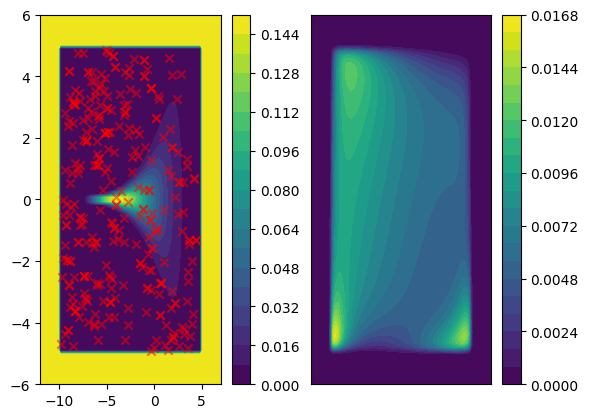

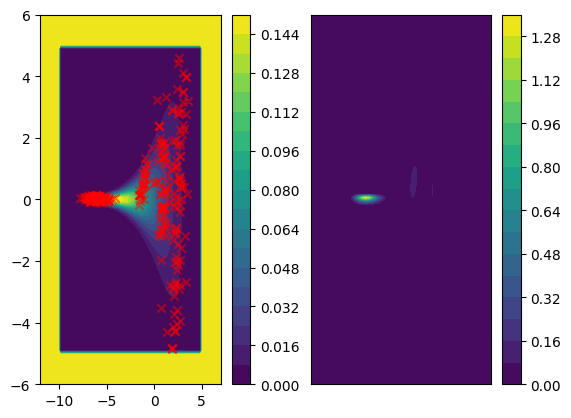

0/200: The model now has 20 components 


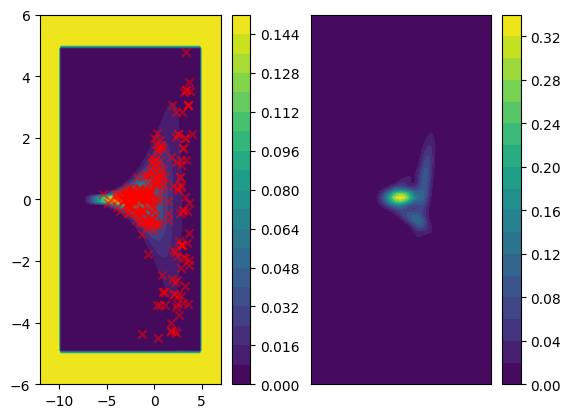

10/200: The model now has 20 components 


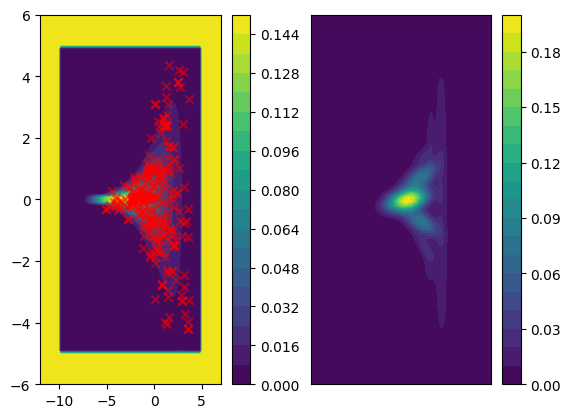

20/200: The model now has 20 components 


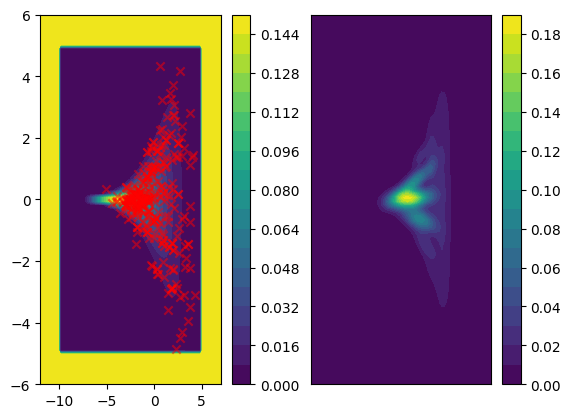

30/200: The model now has 20 components 


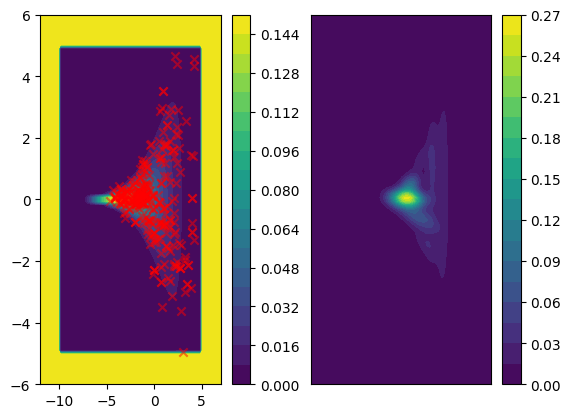

40/200: The model now has 20 components 


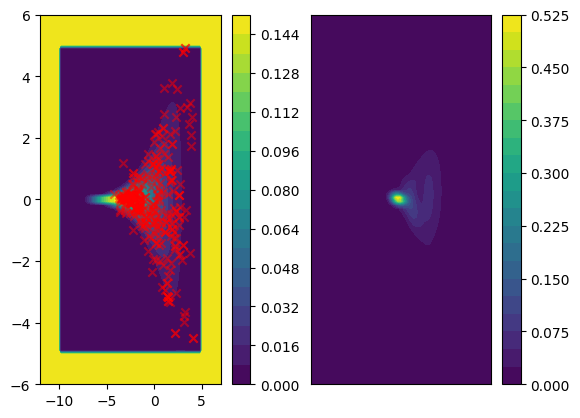

50/200: The model now has 20 components 


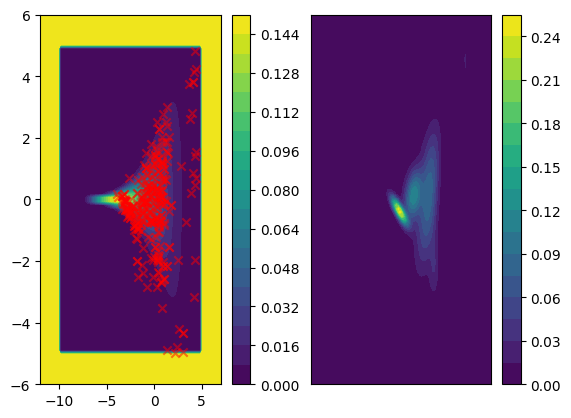

60/200: The model now has 20 components 


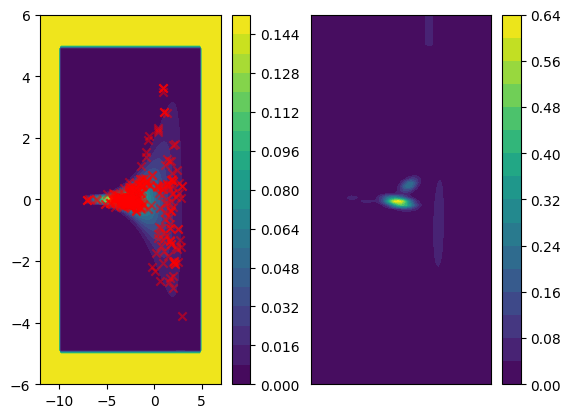

70/200: The model now has 20 components 


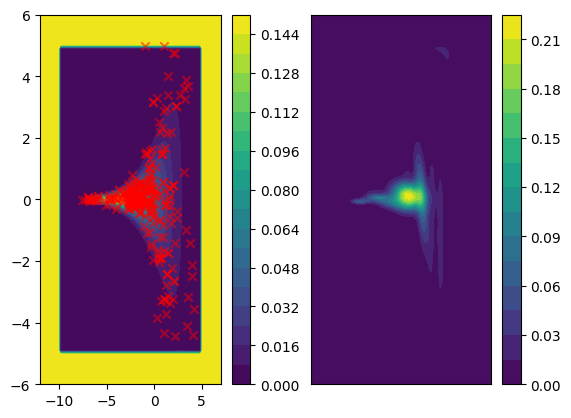

80/200: The model now has 20 components 


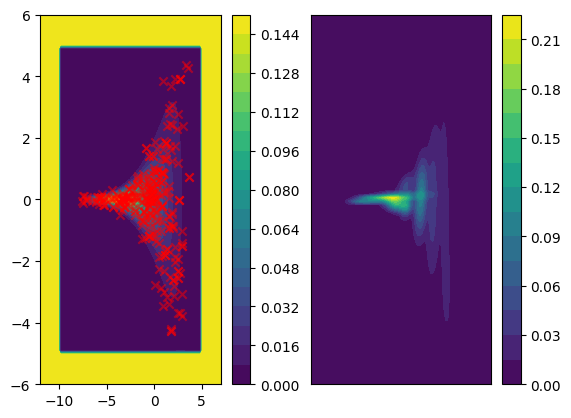

90/200: The model now has 20 components 


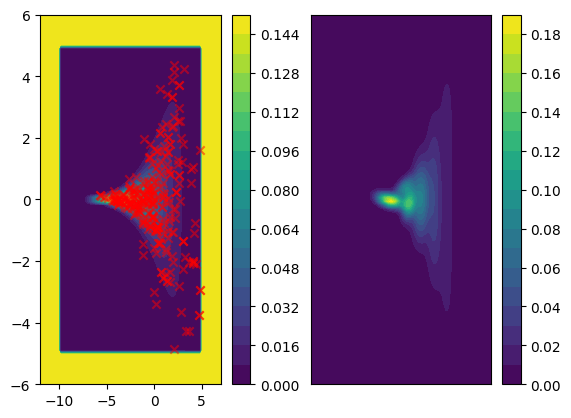

100/200: The model now has 20 components 


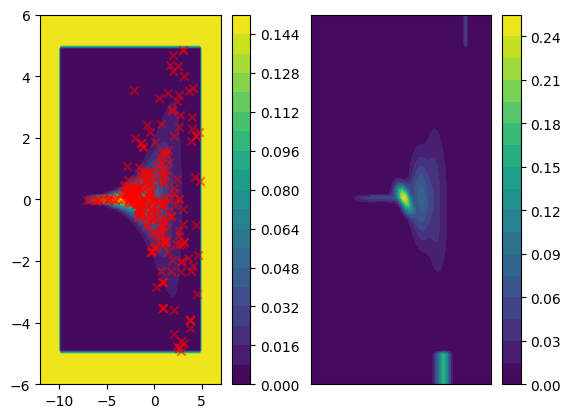

110/200: The model now has 20 components 


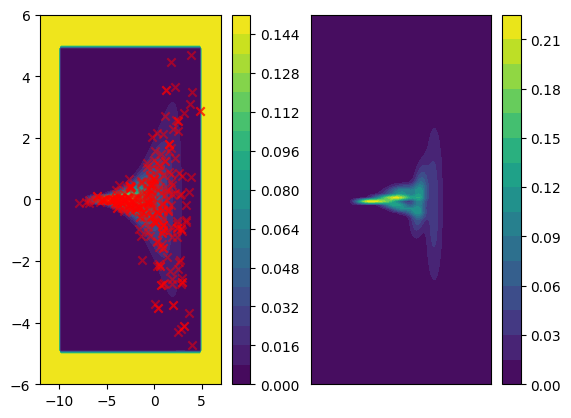

120/200: The model now has 20 components 


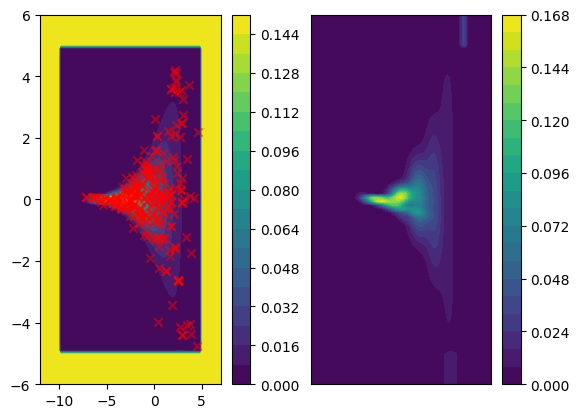

130/200: The model now has 20 components 


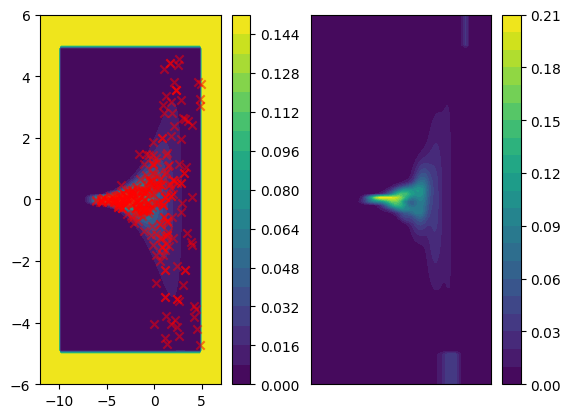

140/200: The model now has 20 components 


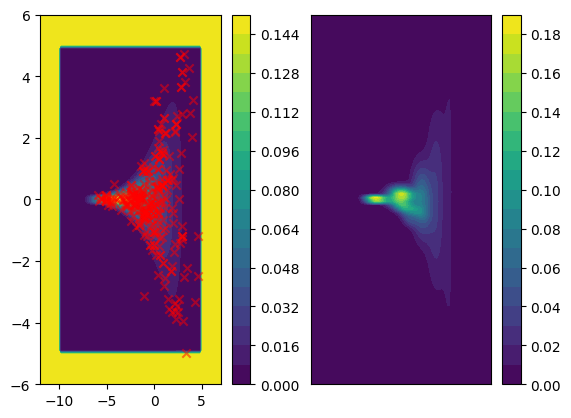

150/200: The model now has 20 components 


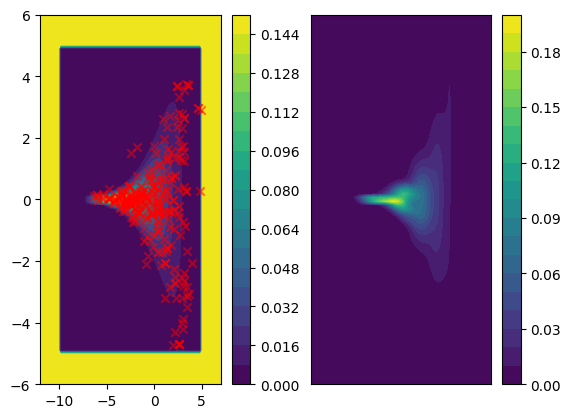

160/200: The model now has 20 components 


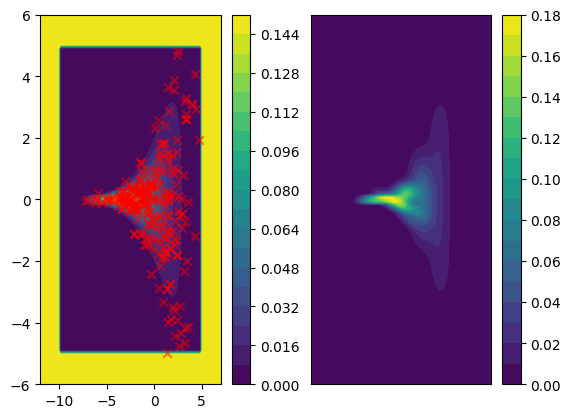

170/200: The model now has 20 components 


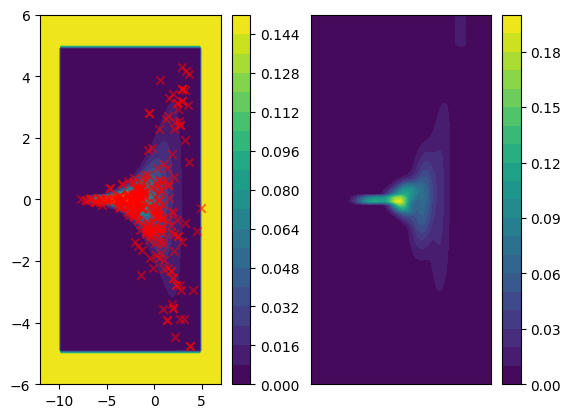

180/200: The model now has 20 components 


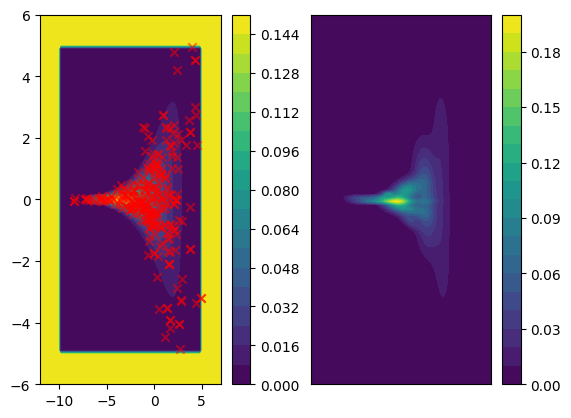

190/200: The model now has 20 components 


In [6]:
iterations = 200
seed = 23
eval_freq = 10
n_eval_samples= 1000
target_samples = target.sample(jax.random.PRNGKey(0), (n_eval_samples,))
target_log_prob = jax.jit(lambda x : target.log_prob(x))
rng =jax.random.PRNGKey(seed)
key, rng = jax.random.split(rng)
timer = 0
state = initial_train_state
def _insert_buffer(train_state: GMMTrainingState, key: chex.Array, target_log_prob_fn):
    def get_target_grads(samples: chex.Array) -> Tuple[chex.Array, chex.Array]:
        # samples = jnp.tanh(samples) * (high-low)/2 + (high+low)/2
        target, gradient = jax.vmap(jax.value_and_grad(target_log_prob_fn))(samples)
        # target += jnp.log(1- ((2*samples-(low+high))/(high-low))**2).sum(-1)
        return gradient, target
    key, subkey = jax.random.split(key)
    new_samples, mapping = gmm_network.sample_selector.select_samples(train_state.model_state,
                                        subkey)
    new_target_grads, new_target_lnpdfs = get_target_grads(new_samples)
    new_sample_db_state = gmm_network.sample_selector.save_samples(train_state.model_state, train_state.sample_db_state, new_samples, new_target_lnpdfs, new_target_grads, mapping)
    return train_state._replace(sample_db_state=new_sample_db_state)
def _train(carry, _):
    state, key = carry
    key, subkey = jax.random.split(key)
    state = train_iter(state, subkey, target_log_prob)
    return (state, key), _
@jax.jit
def jitted_train(state, key):
    (state, _), _ = jax.lax.scan(_train, (state, key), (), length=eval_freq)
    return state
for _ in range(20):
    key, subkey = jax.random.split(key)
    state = _insert_buffer(state, key, target_log_prob)
logger = eval_fn(*eval(rng, state, target_log_prob, n_eval_samples, target_samples))
# jax.config.update("jax_disable_jit", True) 
assert iterations % eval_freq == 0
num_eval_calls = iterations // eval_freq

global_step = 0
for _ in range(num_eval_calls):
    iter_time = time()
    key, subkey = jax.random.split(key)
    
    # state = train_iter(state, subkey, target_log_prob)
    # (state, _), _ = jax.lax.scan(_train, (state, subkey), (), length=eval_freq)
    state = jitted_train(state, subkey)
    # step+=1
    timer += time() - iter_time
    key, subkey = jax.random.split(key)
    logger = eval_fn(*eval(subkey, state, target_log_prob, n_eval_samples, target_samples))
    logger['stats/num_samples'] = [state.sample_db_state.num_samples_written]
    logger['stats/num_components'] = [state.model_state.gmm_state.num_components]
    print(f"{_*eval_freq}/{iterations}: "
            f"The model now has {state.model_state.gmm_state.num_components} components ")
